## By: Oliver Muellerklein 

# Interaction with the World Homework (#3)
Python Computing for Data Science (c) J Bloom, UC Berkeley, 2016

# 1) Monty: The Python Siri

Let's make a Siri-like program with the following properties:
   - record your voice command
   - use a webservice to parse that sound file into text
   - based on what the text, take three different types of actions:
       - send an email to yourself
       - do some math
       - tell a joke

So for example, if you say "Monty: email me with subject hello and body goodbye", it will email you with the appropriate subject and body. If you say "Monty: tell me a joke" then it will go to the web and find a joke and print it for you. If you say, "Monty: calculate two times three" it should response with printing the number 6.

Hint: you can use speed-to-text apps like Houndify to return the text (but not do the actions). You'll need to sign up for a free API and then follow documentation instructions for using the service within Python. 

In [1]:
import sys
import time
import numpy as np
from ipywidgets import widgets as wdg
from ipywidgets import interact
from IPython.display import display 

# Step 1: record voice command 

def getAudio(getURL):
    
    extTmp = os.path.splitext(getURL)
    extFull = extTmp[1].replace(".", "")
    extLower = extFull.lower()
    
    # Get proper extension
    if (extLower == "mp3"):
        extt = "mpeg"
    else:
        extt = extLower
    
    # Need MIME types for permission through browsers
    thisMime = "audio/" + extt
    
    # Write to DOM / HTML - similar to JS; jQuery etc. 
    toDOM = """<h4>{getURL}</h4>
                <audio controls>
                    <source src = 'files/{getURL}' type = '{thisMime}'>
                    Error in browser playback. Alt player:
                    <a href = 'files/{getURL}'>play this.</a>
                </audio>"""
    
    display(HTML(toDOM.format(**locals())))


In [2]:
import wave
import pyaudio
from pyaudio import paInt16 as py16

class AudioWriteBack:
    
    def __init__(self, audioWAV):
        self.audioWAV = audioWAV
    
    def writeFramesBack(self, audioData, audioFrames, audioTime, audioStatus):
        self.audioWAV.writeframes(audioData)
        return audioData, pyaudio.paContinue

class AudioRecorder:
    
    def __init__(self, audioFile = "fooBar.wav", audioMode = "wb"):
        
        self.audioFile = audioFile
        self.audioMode = audioMode
        self.audioChn = None
        self.audioRt = None
        self.audioChunk = None   # aka Frames per buffer
        self.audioWAV = None
        self.pypyAudio = pyaudio.PyAudio()
        #self.audioCallback = callback
        self.readyRecord = True
        
    def setReadyState(self):
        if (self.readyRecord == True):
            self.readyRecord = False
        elif (self.readyRecord == False):
            self.readyRecord = True
        
    def setParams(self):
        self.audioChn = 1
        self.audioRt = 16000
        self.audioChunk = 1024
        
    def estAudio(self):
        self.audioWAV = wave.open(self.audioFile, self.audioMode)
        self.audioWAV.setnchannels(self.audioChn)
        self.audioWAV.setsampwidth(self.pypyAudio.get_sample_size(py16))
        self.audioWAV.setframerate(self.audioRt)
        
    # Need start recording 
    def initRec(self):
        self.stream = self.pypyAudio.open(format = py16,
                                         channels = self.audioChn,
                                         rate = self.audioRt,
                                         input = True,
                                         frames_per_buffer = self.audioChunk,
                                         input_device_index = 0,
                                         stream_callback = self.writeFramesBack())
    
    # Need stop recording 
    def abortRec(self):
        self.stream.stop_stream()
    
    # Need callback to do start and stop
    def writeFramesBack(self):
        def audioCallback(audioData, audioFrames, audioTime, audioStatus):
            self.audioWAV.writeframes(audioData)
            return audioData, pyaudio.paContinue
        return audioCallback
    
    # Close out and exit
    def getClose(self):
        self.stream.close()
        self.pypyAudio.terminate()
        self.audioWAV.close()

In [3]:
# Initialize recorder class and write

## Initially tried with split class for callback (want to revisit later)
#audioCB = AudioWriteBack()
#setAudio = AudioRecorder(audioCB.writeFramesBack)

setAudio = AudioRecorder()
setAudio.setParams()
setAudio.estAudio()
#setAudio.initRec()
#setAudio.abortRec()

In [4]:
from ipywidgets import widgets as wiggie
from ipywidgets import interact
from IPython.display import display as showw

# Recording time:

def setRecord(wiggieBtn):
    
    if (setAudio.readyRecord):
        print("\nInitialize recording - GO GO GO!")
        setAudio.initRec()
    else:
        print("\nFinished recording!")
        setAudio.abortRec()
        setAudio.getClose()
        
    setAudio.setReadyState() 
    
    return 

wHTML = wiggie.Button(description = "Start recording!")
wHTML.on_click(setRecord)
showw(wHTML)


Initialize recording - GO GO GO!

Finished recording!


In [ ]:
# Step 2: interact with webservice and parse sound file to text 

import houndify

BUFFER_SIZE = 512
CLIENT_ID = "nJKD11KrJoXe9MkmNGLNsQ=="
CLIENT_KEY = "SWZIkIISulQpMI6Zir5QJ2leBN_XlOALHs_KJpaDtKJxYTOTm2h6ifLuYCFss-RzQye9NCBlWlwZhE_LMEWkow=="

def getVoiceTxt(wVoice):
    
    class VoiceListener(houndify.HoundListener):
        def onPartialTranscript(self, transcript):
            nonlocal result
            result = transcript
            
    houndClient = houndify.StreamingHoundClient(CLIENT_ID, CLIENT_KEY, "fooBarUser")
    houndAudio = wave.open(wVoice)
    houndFR = houndAudio.getframerate()
    houndClient.setSampleRate(houndFR)
    houndFrames = houndAudio.readframes(BUFFER_SIZE)
    finishedd = False
    
    # Open connection to Houndify API via class callbacks 
    # Note: much help from classmates on how to construct this
    houndClient.start(VoiceListener())
    while not finishedd:
        finished = houndClient.fill(houndFrames)
        houndFrames = houndAudio.readframes(BUFFER_SIZE)
        if len(houndFrames) == 0:
            finishedd = True
            break
    houndClient.finish()
    return True


houndTalk = getVoiceTxt("fooBar.wav")
print("Your Houndify transcript: ", houndTalk)

In [216]:
import json
import smtplib
from urllib.request import urlopen
from email.mime.multipart import MIMEMultipart
from email.mime.base import MIMEBase
from email.mime.text import MIMEText
from email import encoders
from email.utils import COMMASPACE, formatdate

# Step 3: based on text take 1 of 3 actions - send email, do math, tell joke 

# For ii) math - basic math, add, subtract, divide, multiply  
    
class AudioToAction:
    
    def __init__(self, getTxt):
        
        self.getTxt = getTxt
        self.stripTxt = np.array(self.getTxt.split(" "))
        self.modTxtArr = None
        self.lowrTxt = None
        self.toEmailArr = np.array(["email", "send", "contact", "contacts"])
        self.toMathArr = np.array(["calculate", "math", "sum", "add", "plus", "subtract", "minus", "take", "divide", "multiply"])
        self.toJokeArr = np.array(["joke", "funny", "laugh", "haha", "comedy"])
        self.specialEmail = np.array(["to", "from", "subject", "body"])
        
        self.numss = {"zero":0, "one":1, "two":2, "three":3, "four":4, "five":5, 
                      "six":6, "seven":7, "eight":8, "nine":9}
        self.tenss = {"ten":10, "eleven":11, "twelve":12, "thirteen":13, "fourteen":14, "fifteen":15, 
                      "sixteen":16, "seventeen":17, "eighteen":18, "nineteen":19}
        self.hunss = {"hundred":100, "thousand":1000}
        
        self.inEmailIdx = None
        self.inMathIdx = None
        self.inJokeIdx = None
        self.mathResult = None
        
    def getFormattr(self):
        
        print("\n--------");
        return True
        
    def getStripTxt(self, doPrint = False):
        
        if (doPrint):
        
            self.getFormattr()
            print("\nOriginal Text:")
            print("_", self.getTxt)
            self.getFormattr()
            print("\n\nStripped Text:")
            print("_", self.stripTxt)
        
        # 1) dropout commas & 2) to lowercase
        tmpTxt = self.stripTxt
        self.modTxtArr = np.array([iRepl.replace(",", " ") for iRepl in tmpTxt])
        self.lowrTxt = np.array([i.lower() for i in self.modTxtArr])
        
    def listenTxt(self):
        # Decide which action to take 
        
        self.getFormattr()
        inEmail = np.any(self.toEmailArr[:, np.newaxis] == self.lowrTxt, axis = 1)
        inMath = np.any(self.toMathArr[:, np.newaxis] == self.lowrTxt, axis = 1)
        inJoke = np.any(self.toJokeArr[:, np.newaxis] == self.lowrTxt, axis = 1)
        
        self.inEmailIdx = inEmail
        self.inMathIdx = inMath
        self.inJokeIdx = inJoke
        
        isInEmail = np.where(inEmail)
        isInMath = np.where(inMath)
        isInJoke = np.where(inJoke)
        
        if (isInEmail[0].size >= 1):
            
            print("Attempting to send an email...")
            self.setEmail()
            
        elif (isInMath[0].size >= 1):
            
            print("Attemting to calculate...")
            self.setCalc()
            
        elif (isInJoke[0].size >= 1):
            
            self.getFormattr()
            print("^__^\n")
            self.setJoke()
            
        else:
            
            print("No information found from text.")
            self.getFormattr()
            
         
        
    def setEmail(self):

        spEmailIdx = np.any(self.specialEmail[:, np.newaxis] == self.lowrTxt, axis = 1)        
        subbjIdx = (self.lowrTxt == "subject")
        boddyIdx = (self.lowrTxt == "body") 
        subbjWhere = np.where(subbjIdx == True)
        boddyWhere = np.where(boddyIdx == True)
        
        allSubbj = []
        allBoddy = []
        for i in range(self.lowrTxt.size):
            if (i > subbjWhere[0]):
                
                if (i >= boddyWhere[0]):
                    if (i != boddyWhere[0]): 
                        allBoddy.append(self.lowrTxt[i])
                else:
                    allSubbj.append(self.lowrTxt[i])
           
        self.subbj = " ".join(allSubbj)
        self.texxt = " ".join(allBoddy)
        
        self.getEmail() 
    
    def setCalc(self):
        # Setup doing calculations
        
        allNums = []
        allActions = []
        for i in range(self.inMathIdx.size):
            if (self.inMathIdx[i]):
                tmpAction = self.lowrTxt[self.lowrTxt == self.toMathArr[i]]
                #tmpAction = self.lowrTxt[i]
                allActions.append(tmpAction[0])

        for item in self.numss.items():
            if (item[0] in self.lowrTxt):
                allNums.append(item[1])
        
        self.getCalc(allNums, allActions)
    
    def setJoke(self):
        # Setup telling joke
        
        rawJSONN = urlopen("http://api.icndb.com/jokes/random").read()
        decJSONN = rawJSONN.decode('UTF-8')
        dictJSONN = eval(decJSONN)
        self.getFormattr()
        print(dictJSONN['value']['joke'])
        
    def getCalc(self, allNums, allActions):
        
        if (allActions[0] == ("plus" or "add" or "sum")):
        
            self.mathResult = allNums[1] + allNums[0]
            
        elif (allActions[0] == ("minus" or "subtract" or "take")):
            
            self.mathResult = allNums[1] - allNums[0]

        elif (allActions[0] == "divide"):
            
            self.mathResult = allNums[0] / allNums[1]
            
        elif (allActions[0] == "multiply"):
            
            self.mathResult = allNums[1] * allNums[0]
            
        else: 
            
            self.mathResult = "Nothing to show!"
            
        print("\nAnd the math result: ", self.mathResult)
        self.getFormattr()
    
    def getEmail(self, fromm = "omuellerklein@berkeley.edu", 
                 passwrdd = "foobarpassword", toWhom = "omuellerklein@berkeley.edu"):
        
        msg = MIMEMultipart()
        msg["Date"] = formatdate(localtime = True)
        msg["From"] = fromm
        msg["To"] = toWhom
        msg["Subject"] = self.subbj
        msg.attach(MIMEText(self.texxt))
        
        mailServer = smtplib.SMTP("smtp.gmail.com", 587)
        mailServer.starttls()
        mailServer.login(fromm, passwrdd)
        mailServer.sendmail(fromm, toWhom, msg.as_string())
        mailServer.close() 

    
#exMath = AudioToAction("woWW, ok do two divide eight")
#exMath.getStripTxt()
#exMath.listenTxt()

#exEmail = AudioToAction("hello, please email with subject hello body how are you")
#exEmail.getStripTxt()
#exEmail.listenTxt()

exJoke = AudioToAction("please tell me a joke")
exJoke.getStripTxt()
exJoke.listenTxt()


--------

--------
^__^


--------
Scotty in Star Trek often says &quot;Ye cannae change the laws of physics.&quot; This is untrue. Chuck Norris can change the laws of physics. With his fists.


# 2) Write a program that identifies musical notes from sound (AIFF) files. 

  - Run it on the supplied sound files (12) and report your program’s results. 
  - Use the labeled sounds (4) to make sure it works correctly. The provided sound files contain 1-3 simultaneous notes from different organs.
  - Save copies of any example plots to illustrate how your program works.
  
  https://piazza.com/berkeley/fall2016/ay250/resources -> hw3_sound_files.zip

Hints: You’ll want to decompose the sound into a frequency power spectrum. Use a Fast Fourier Transform. Be care about “unpacking” the string hexcode into python data structures. The sound files use 32 bit data. Play around with what happens when you convert the string data to other integer sizes, or signed vs unsigned integers. Also, beware of harmonics.

In [507]:
import sys
#sys.executable
#sys.path

In [509]:
# References: 

# http://samcarcagno.altervista.org/blog/basic-sound-processing-python/

# https://gist.github.com/endolith/255291

# http://www.cs.tut.fi/sgn/arg/intro/basics.html

# https://github.com/endolith/waveform-analyzer/blob/master/frequency_estimator.py

In [510]:
"""
Steps to homework: 

1. Read in AIF to get audio files as bytes to numeric (conversion) 
2. Plot amp vs time 
3. Perform real-FFT on time-series (amp vs time), get power spectrum and others
4. Plot power spectrum 
5. Find indices of top n powerful frequencies 
6. Perform kmeans clustering or distance analyses ... to get dominate tones (DomTones) 
7. With DomTones divide them by standard notes (12 notes in standard music scale) 

* C = 16.35 Hz
* C# = 17.32 Hz
* D = 18.35 Hz
* D# = 19.45 Hz
* E = 20.60 Hz
* F = 21.83 Hz
* F# = 23.12 Hz
* G = 24.50 Hz
* G# = 25.96 Hz
* A = 27.50 Hz
* A# = 29.14 Hz
* B = 30.87 Hz

"""

'\nSteps to homework: \n\n1. Read in AIF to get audio files as bytes to numeric (conversion) \n2. Plot amp vs time \n3. Perform real-FFT on time-series (amp vs time), get power spectrum and others\n4. Plot power spectrum \n5. Find indices of top n powerful frequencies \n6. Perform kmeans clustering or distance analyses ... to get dominate tones (DomTones) \n7. With DomTones divide them by standard notes (12 notes in standard music scale) \n\n* C = 16.35 Hz\n* C# = 17.32 Hz\n* D = 18.35 Hz\n* D# = 19.45 Hz\n* E = 20.60 Hz\n* F = 21.83 Hz\n* F# = 23.12 Hz\n* G = 24.50 Hz\n* G# = 25.96 Hz\n* A = 27.50 Hz\n* A# = 29.14 Hz\n* B = 30.87 Hz\n\n'

In [511]:
# Note: 200 - 6000 Hz is range + buffer around most sensitive human hearing 

In [572]:
import scipy.io.wavfile
import aifc
import numpy as np

class AudioPlats(object):
    
    def __init__(self, ffile):
        self.allChunks = []
        self.lowChunks = []
        self.hiChunks = []
        self.allSlopes = []
        self.deltax = []
        self.deltay = []
        self.ffile = ffile
        
        self.fr = None
        self.ampDat = None
        self.data = None
        self.audioData = None
        self.audioFFT = None
        self.audioAmp = None
        self.audioPower = None
        self.audioPhase = None
        self.audioFreqs = None
        self.audioIdx = None
        self.blankAxis = None
        self.powerMax = None
        self.freqMax = None
        self.powerMaxArr = None
        self.audioFreqsArr = None
        self.nFreqsK = None
        
        # Kmeans on dominate frequencies 
        self.k1 = None
        self.k2 = None
        self.k3 = None
        self.domFreqA = None
        self.domFreqB = None
        
    def readData(self):
        
        #audio = aifc.open("hw3_data/sound_files/F3_popOrgan.aif")
        #audio = aifc.open("hw3_data/sound_files/1.aif")
        audio = aifc.open("hw3_data/sound_files/%s" % self.ffile)
        frames = audio.getnframes()
        channels = audio.getnchannels()
        frameRate = audio.getframerate()
        self.fr = frameRate
        datBytes = audio.readframes(frames)
        dat = np.fromstring(datBytes, dtype = np.int32)
        self.ampDat = dat
        self.getPhase(dat, frameRate)
        
    def getPhase(self, dat, frameRate):
        
        # Get basic audio properties 
        
        self.audioData = dat
        self.audioFFT = np.fft.rfft(self.audioData)
        self.audioAmp = np.abs(self.audioFFT)
        self.audioPower = np.abs(self.audioFFT)**2
        self.audioPhase = np.angle(self.audioFFT)
        self.audioFreqs = np.fft.fftfreq(self.audioFFT.size, 1 / frameRate)
        self.blankAxis = np.linspace(0, frameRate / 2, len(self.audioFFT))
        self.audioIdx = np.argsort(self.audioFreqs)
        
    def kFreqs(self, k):
        
        # Get k-largest (top k power) frequencies
        
        TaudioFreqsIdx = audioFreqs[self.audioIdx]
        audioPowerIdx = audioPower[self.audioIdx]
        self.powerMax = audioPowerIdx.max()
        self.freqMax = TaudioFreqsIdx.max()
        audioPowerMaxIdx = audioPowerIdx.argmax()
        TpowerMaxIdx = audioPowerIdx.argsort()
        
        self.powerMaxArr = TpowerMaxIdx
        self.audioFreqsArr = TaudioFreqsIdx
        audioFreqsK = self.audioFreqsArr[self.powerMaxArr[-k:], ]
        nonnegFreqsK = audioFreqsK[audioFreqsK > 0]
        self.nFreqsK = nonnegFreqsK[::-1]
        self.data = np.sort(self.nFreqsK)
        
    def zeroSlope(self, chunksize = 10, maxSlope = .001):
        
        dat = np.asarray(self.data)
        midIdx = chunksize / 2
        quartIdx = np.around(midIdx / 2).astype(int32)
        #maxFreq = np.max(dat)
        maxFreq = self.freqMax
        
        for i in range(np.size(dat) - chunksize):
            chunk = dat[i : (i + chunkSize)]
            dy = chunk[-1] - chunk[0]
            dx = chunksize
            
            self.deltay.append(dy)
            self.deltax.append(dx)
        
            #if (0 <= ((dy / dx) / maxFreq) < maxSlope):
            if ((dy / dx) >= maxSlope):
                self.allChunks.append(chunk[midIdx])
                self.lowChunks.append(chunk[midIdx - quartIdx])
                self.hiChunks.append(chunk[midIdx + quartIdx])
                self.allSlopes.append((dy / dx))
                
    def getDomFreqs(self):
        
        # Perform kmeans to get dominate frequencies   
        
        kClus = kmeans(self.allChunks, 2)
        self.k1 = kClus[0][0]
        self.k2 = kClus[0][1]
        #self.k3 = kClus[0][2]
        
        k1k2Diff = np.abs(self.k1 - self.k2)
        #k1k3Diff = np.abs(self.k1 - self.k3)
        #k2k3Diff = np.abs(self.k2 - self.k3)
        
        k1k2Combo = None
        #k1k3Combo = None
        #k2k3Combo = None
        
        if (k1k2Diff < 50):
            k1k2Combo = np.mean(self.k1 + self.k2)
            self.domFreqA = k1k2Combo
            self.domFreqB = None
        else:
            self.domFreqA = self.k1
            self.domFreqB = self.k2
                
        #if (k1k3Diff < 50):
        #    k1k3Combo = np.mean(self.k1 + self.k3)
        #    
        #if (k2k3Diff < 50):
        #    k2k3Combo = np.mean(self.k2 + self.k3)
            
        
    def plotAmpTime(self):
        
        dat = self.ampDat
        time = arange(size(dat)) / float(self.fr)
        plotTitle = ("Audio Analysis")

        fig = plt.figure(figsize = (7, 4.5))
        ax1 = fig.add_subplot(1, 1, 1)
        ax1.plot(time, dat, color = "red", linestyle = "-")
        ax1.set_xlabel("Time [s]")
        ax1.set_ylabel("Amplitude")
        ax1.set_xlim(min(time), max(time))
        ax1.set_title(plotTitle)
        
    def plotStepFreqs(self):
        plt.plot(self.data)
        

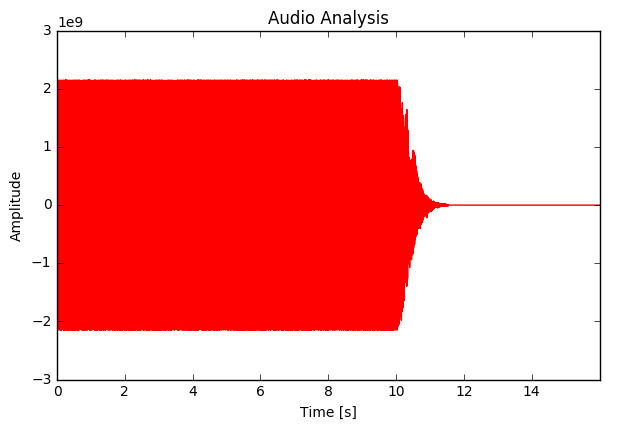

In [580]:
thisAudio = AudioPlats("1.aif")
thisAudio.readData()
thisAudio.kFreqs(20)

%matplotlib inline

thisAudio.plotAmpTime()

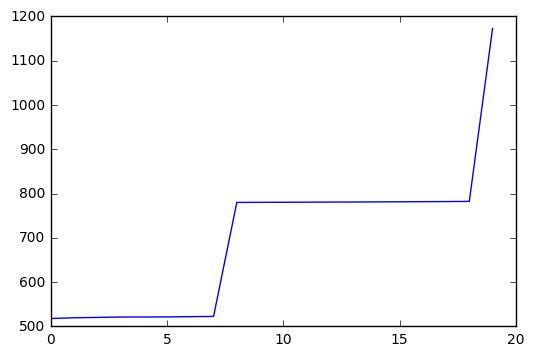

In [574]:
%matplotlib inline

thisAudio.plotStepFreqs()

In [575]:
#thisAudio.zeroSlope(chunksize = 2, maxSlope = 0.015)
thisAudio.zeroSlope(chunksize = 2, maxSlope = 100)
thisAudio.getDomFreqs()

/Users/kschocz/Library/Python/3.5/lib/python/site-packages/ipykernel/__main__.py:103: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/kschocz/Library/Python/3.5/lib/python/site-packages/ipykernel/__main__.py:104: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/kschocz/Library/Python/3.5/lib/python/site-packages/ipykernel/__main__.py:105: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [576]:
# I decide to subset the top 20 most powerful frequencies (from Power Spectrum)
# and show the top two dominate frequencies as the main frequencies 
# of this soundfile. 
# Note: domFreqA and domFreqB are not ordered. 

thisAudio.domFreqA

521.26637963044323

In [577]:
thisAudio.domFreqB

781.08869512068486

In [578]:
# If desired, these frequencies can be divided / floored by the standard musical scale 
# to find what notes these are octaves of. 

# E.g. For "1.aif" either domFreqA or domFreqB hit almost no remainder 
#    with (A) 27.50 Hz division

# allNotes[9] = A 
# C = 16.35 Hz
# C# = 17.32 Hz
# D = 18.35 Hz
# D# = 19.45 Hz
# E = 20.60 Hz
# F = 21.83 Hz
# F# = 23.12 Hz
# G = 24.50 Hz
# G# = 25.96 Hz
# A = 27.50 Hz
# A# = 29.14 Hz
# B = 30.87 Hz

allNotes = [16.35, 17.32, 18.35, 19.45, 20.60, 21.83, 23.12, 24.50, 25.96, 27.50, 29.14, 30.87]

thisAudio.domFreqA / allNotes[9]

18.955141077470664

In [579]:
thisAudio.domFreqB / allNotes[9]

28.403225277115812